In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May 15 23:45:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    56W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
pip install pytesseract

In [5]:
pip install pydicom

In [6]:
pip install albumentations

In [7]:
import time
import csv
import os
import copy
import re
import shutil
import pydicom
import pytesseract
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import albumentations as A
from albumentations.pytorch import ToTensor
from scipy import interp

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
class ImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform         
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx,0]
    data = pydicom.dcmread(img_name) # read dicom file
    arr = data.pixel_array # read image into pixel data
    shape = arr.shape
    if len(shape) == 4:
      arr = arr[0,:,:,0] # get the first slide of image
    elif len(shape) == 3:
      arr = arr[:,:,0] # get the first slide of image
    else:
      arr = arr
    image = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)

    labels = np.array(self.df.drop(['image_name'],axis=1))
    label = labels[idx]

    if self.transform:
      image = self.transform(image=image)["image"]
    
    return image, label

In [10]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Data_testing/file_names.csv")

means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)

albumentation_train_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                      A.RandomCrop(height=224, width=224),
                                      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                                      A.RandomBrightnessContrast(p=0.5),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                    ])
albumentation_val_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.CenterCrop(height=224, width=224),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                  ])

(train_df, val_df) = train_test_split(df, test_size = 0.4)
(val_df, test_df) = train_test_split(val_df, test_size = 0.5)

train_dataset = ImageDataset(train_df, transform=albumentation_train_transform)
val_dataset = ImageDataset(val_df, transform=albumentation_val_transform)
test_dataset = ImageDataset(test_df, transform=albumentation_val_transform)

batch_num = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)

In [11]:
def bottleneck_block(in_channel, mid_channel, out_channel):
  block = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=mid_channel, kernel_size=1, bias=False),
      nn.BatchNorm2d(mid_channel),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(mid_channel),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=mid_channel, out_channels=out_channel, kernel_size=1, bias=False),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True),
  )
  return block

def bottleneck(in_channel, mid_channel, out_channel):
  layers = []
  layers.append(bottleneck_block(in_channel, mid_channel, out_channel))
  return nn.Sequential(*layers)

In [12]:
class CNN_Bottleneck(torch.nn.Module):
  def __init__(self):
    super(CNN_Bottleneck, self).__init__()                                                                          
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.block1 = bottleneck(64, 32, 64)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(128)
    self.block2 = bottleneck(128, 64, 128)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)      
    self.bn3 = nn.BatchNorm2d(256)     
    self.block3 = bottleneck(256, 128, 256)                                                                  
    self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
    self.bn4 = nn.BatchNorm2d(512)
    self.block4 = bottleneck(512, 256, 512)
    self.linear1 = nn.Linear(512*12*12, 4096)
    self.linear2 = nn.Linear(4096, 1024)
    self.linear3 = nn.Linear(1024, 4)
    self.sigmoid = nn.Sigmoid()
    self.maxpool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x): #224
    identity = [None]*3
    x = self.maxpool(self.relu(self.bn1(self.conv1(x)))) #113
    identity[0] = x
    x = self.block1(x)
    x = self.maxpool(self.relu(self.bn2(self.conv2(torch.cat([x,identity[0]],1))))) #58
    identity[1] = x
    x = self.block2(x) 
    x = self.maxpool(self.relu(self.bn3(self.conv3(torch.cat([x,identity[1]],1))))) #30
    identity[2] = x
    x = self.block3(x)
    x = self.maxpool(self.relu(self.bn4(self.conv4(torch.cat([x,identity[2]],1))))) #16
    x = self.block4(x)
    x = x.view(x.size(0),-1)
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.linear3(x)
    x = self.sigmoid(x)

    return x

In [13]:
def calculate_metrics(pred, label):
  return {
      "micro_f1":f1_score(y_true=label, y_pred=pred, average='micro'),
      "macro_f1":f1_score(y_true=label, y_pred=pred, average='macro'),
  }

In [14]:
def train_model(train_dataloader, val_dataloader, optimizer, criterion, net, threshold, num_epochs):
  since = time.time()

  tot_train_loss = []
  tot_val_loss = []

  tot_train_acc = []
  tot_val_acc = []
  
  for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch, num_epochs-1))
    print('-' * 10)

    net.train()
    
    train_running_loss = 0.0
    train_loss_values = []

    train_outputs = []
    train_labels = []

    for idx, data in enumerate(train_dataloader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      outputs = net(img)
      loss = criterion(outputs, label.type(torch.float))

      pred = outputs.data > threshold
      pred = pred.type(torch.float)

      loss.backward()
      optimizer.step()
      
      train_loss_values.append(loss.item())
      train_running_loss += loss.item()

      train_outputs.extend(pred.cpu().to(torch.int).numpy())
      train_labels.extend(label.cpu().to(torch.int).numpy())

    train_result = calculate_metrics(np.array(train_outputs), np.array(train_labels))

    net.eval()

    validation_running_loss = 0.0
    val_loss_values = []

    with torch.no_grad():
      val_outputs = []
      val_labels = []
      for val_idx, val_data in enumerate(val_dataloader):
        val_img, val_label = val_data
        val_img = val_img.to(device) 
        val_label = val_label.to(device)

        val_output = net(val_img)

        val_loss = criterion(val_output, val_label.type(torch.float))

        val_pred = val_output.data > threshold
        val_pred = val_pred.type(torch.float)

        val_outputs.extend(val_pred.cpu().to(torch.int).numpy())
        val_labels.extend(val_label.cpu().to(torch.int).numpy())

        val_loss_values.append(val_loss.item())
        validation_running_loss += val_loss.item()

    val_result = calculate_metrics(np.array(val_outputs), np.array(val_labels))

    final_train_loss = train_running_loss/len(train_dataloader)
    final_val_loss = validation_running_loss/len(val_dataloader)

    tot_train_loss.append(final_train_loss)
    tot_val_loss.append(final_val_loss)

    tot_train_acc.append(train_result)
    tot_val_acc.append(val_result)

    print("train loss: {}".format(final_train_loss))
    print("validation loss: {}".format(final_val_loss))
    print("train accuracy:\n",train_result)
    print("validation accuracy:\n",val_result)
    print()

  tot_time = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(tot_time // 60, tot_time % 60))
  
  return net, tot_train_loss, tot_val_loss, tot_train_acc, tot_val_acc 

In [15]:
network = CNN_Bottleneck()
network = network.to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.00001)

In [16]:
train_ft, Bottleneck_train_loss, Bottleneck_val_loss, Bottleneck_train_result, Bottleneck_val_result = train_model(train_dataloader, val_dataloader, optimizer, criterion, network,  0.5, 41)

Epoch: 0/40
----------
train loss: 0.5878815274489554
validation loss: 0.6481691908836364
train accuracy:
 {'micro_f1': 0.5799725651577504, 'macro_f1': 0.349458074001665}
validation accuracy:
 {'micro_f1': 0.5630026809651475, 'macro_f1': 0.2260758444968971}

Epoch: 1/40
----------
train loss: 0.48394047743395757
validation loss: 0.5300362312793732
train accuracy:
 {'micro_f1': 0.6929095354523227, 'macro_f1': 0.5558120737011195}
validation accuracy:
 {'micro_f1': 0.7506925207756232, 'macro_f1': 0.7075628644109768}

Epoch: 2/40
----------
train loss: 0.40411139789380524
validation loss: 0.3412542974948883
train accuracy:
 {'micro_f1': 0.7829585798816568, 'macro_f1': 0.7447787908091006}
validation accuracy:
 {'micro_f1': 0.8159645232815963, 'macro_f1': 0.7705973762847573}

Epoch: 3/40
----------
train loss: 0.35493735733785126
validation loss: 0.30612778961658477
train accuracy:
 {'micro_f1': 0.8113609467455621, 'macro_f1': 0.7806905331703975}
validation accuracy:
 {'micro_f1': 0.84431977

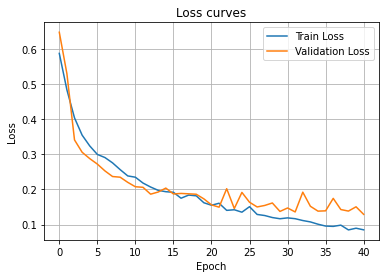

In [17]:
plt.plot(Bottleneck_train_loss, label='Train Loss')
plt.plot(Bottleneck_val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

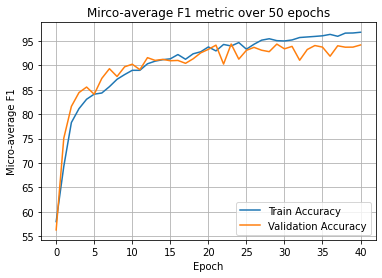

In [18]:
a = []
b = []
for result in Bottleneck_train_result:
  a.append(result["micro_f1"]*100)

for result in Bottleneck_val_result:
  b.append(result["micro_f1"]*100)

plt.plot(a, label='Train Accuracy')
plt.plot(b, label='Validation Accuracy')
plt.legend()
plt.title("Mirco-average F1 metric over 50 epochs")
plt.xlabel("Epoch")
plt.ylabel("Micro-average F1")
plt.grid()

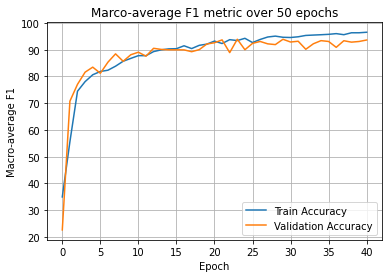

In [19]:
a = []
b = []
for result in Bottleneck_train_result:
  a.append(result["macro_f1"]*100)

for result in Bottleneck_val_result:
  b.append(result["macro_f1"]*100)

plt.plot(a, label='Train Accuracy')
plt.plot(b, label='Validation Accuracy')
plt.legend()
plt.title("Marco-average F1 metric over 50 epochs")
plt.xlabel("Epoch")
plt.ylabel("Macro-average F1")
plt.grid()

In [20]:
def test_model(test_dataloader, optimizer, criterion, net, threshold):
  test_outputs = []
  test_labels = []
  since = time.time()

  net.eval()

  for idx, data in enumerate(test_dataloader):
    img, label = data
    img = img.to(device)
    label = label.to(device)

    outputs = net(img)

    pred = outputs.data > threshold
    pred = pred.type(torch.float)
      
    test_outputs.extend(pred.cpu().to(torch.int).numpy())
    test_labels.extend(label.cpu().to(torch.int).numpy())

  test_result = calculate_metrics(np.array(test_outputs), np.array(test_labels))

  tot_time = time.time() - since
  print('Testing complete in {:.0f}m {:.0f}s'.format(tot_time // 60, tot_time % 60))

  return np.asarray(test_outputs), np.asarray(test_labels), test_result 

In [21]:
Bottleneck_test_outputs, Bottleneck_test_labels, Bottleneck_test_result = test_model(test_dataloader, optimizer, criterion, train_ft, 0.5)

Testing complete in 0m 35s


In [22]:
Bottleneck_test_result

{'macro_f1': 0.9391727186712637, 'micro_f1': 0.945176960444136}

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for idx in range(4):
    fpr[idx], tpr[idx], _ = roc_curve(Bottleneck_test_labels[:, idx], Bottleneck_test_outputs[:, idx])
    roc_auc[idx] = auc(fpr[idx], tpr[idx])

fpr["micro"], tpr["micro"], _ = roc_curve(Bottleneck_test_labels.ravel(), Bottleneck_test_outputs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


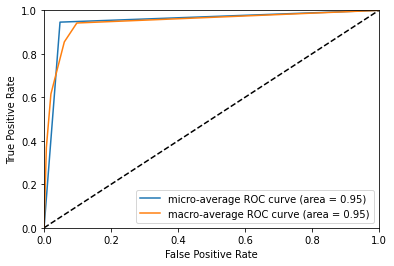

In [24]:
x = np.linspace(0,1)
y = x
plt.plot(x,y,linestyle="dashed",color='black')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [25]:
final_df = pd.DataFrame(data=Bottleneck_train_loss, columns=["train_loss"])
final_df["train_result_micro"] = [data['micro_f1'] for data in Bottleneck_train_result]
final_df["train_result_macro"] = [data['macro_f1'] for data in Bottleneck_train_result]
final_df["val_loss"] = Bottleneck_val_loss
final_df["val_result_micro"] = [data['micro_f1'] for data in Bottleneck_val_result]
final_df["val_result_macro"] = [data['macro_f1'] for data in Bottleneck_val_result]

final_df.to_csv("/content/drive/MyDrive/Output/Bottleneck_train",index=False)

In [26]:
final_df_train = pd.DataFrame(data=Bottleneck_test_labels, columns=["label1","label2","label3","label4"])
final_df_train["pred1"] = Bottleneck_test_outputs[:,0]
final_df_train["pred2"] = Bottleneck_test_outputs[:,1]
final_df_train["pred3"] = Bottleneck_test_outputs[:,2]
final_df_train["pred4"] = Bottleneck_test_outputs[:,3]

final_df_train.to_csv("/content/drive/MyDrive/Output/Bottleneck_test",index=False)